In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [41]:
def get_from_binary(year):
    """
    Read in cleaned and trimmed data for SPY_{year} as a numpy array
    Construct a pandas dataframe from the array
    np.fromfile = 0.5 seconds
    pd.read_csv = 30 seconds
    """
    #read in the binary file 
    arr = np.fromfile('Polygon/Primed/SPY_{}.binary'.format(year), dtype=np.float64)
    
    #reshape the 1d array into 2d
    arr = arr.reshape((int(len(arr)/3), 3))

    #construct a Pandas dataframe
    df  = pd.DataFrame(arr)
    
    #reassign the column names
    df.columns = ['t', 'p', 's']
    
    #make the timestamp the index
    df.set_index('t', inplace=True)
   
    #convert 64bit integer index to datetime (unit = nanoseconds)
    df.index = df.index = pd.to_datetime(df.index, unit='ns')
    
    #convert index to US-Eastern timezone, automatically takes care of daylight savings
    df.index = df.index.tz_localize('UTC').tz_convert('US/Eastern')
    
    return df
    
def OHLCV(df, w):
    """
    For the dataframe :df:, calculate the Open,High,Low,Close,Volume every period :w:
    """
    #resample and calculate OHLCV -- range [w, w+1)
    temp = df.resample(w, label='left',closed='left').agg({'p': 'ohlc', 's': 'sum'})
    temp.columns = ['open','high','low','close','volume']
    
    #forward fill the close price to fill in any missing values
    temp['close'].fillna(method='ffill', inplace=True)
    temp['open'].fillna(temp['close'], inplace=True)
    temp['high'].fillna(temp['close'], inplace=True)
    temp['low'].fillna(temp['close'], inplace=True)
    
    return temp

def bivariate(df, w):
    """
    Calculate the last price and sum of shares traded in each period w
    """
    #resample and calculate last price and sum of shares (volume) for each period :w:
    #range [w, w+1)
    temp = df.resample(w, label='left',closed='left').agg({'p':'last','s':'sum'})
    
    #forward fill the price for missing values
    temp['p'].fillna(method='ffill', inplace=True)
    
    return temp

def aggregate_trades(df, agg_type, w):

    #get aggregated data for the eval_period
    if agg_type == 'ohlcv':
        agg_data = OHLCV(df, w)
                
    elif agg_type == 'bivariate':
        agg_data = bivariate(df, w)
    
    #fill in zero shares with one share so that transform(df) doesn't divide by zero
    agg_data.loc[agg_data['s'] < 1, 's'] = 1.0
    
    return agg_data
    

def transform(df):
    """
    Convert prices and volume to percent different from previous
    """
    #calculate percent difference from previous :w:
    df['p'] = df['p'].pct_change()
    df['s'] = df['s'].pct_change()
    
    #take natural log of returns to get normal distribution
    df['s'] = np.log(1 + df['s'])
    df['p'] = np.log(1 + df['p'])
    
    return df

def strided_window(arr, window_size, step_size):
    """
    Create expanded array of references that effectively create a "memory" for each row,
    where columns are previous rows' data.
    See generate_view() for information on what window_size and step_size are
    https://stackoverflow.com/questions/40084931/taking-subarrays-from-numpy-array-with-given-stride-stepsize/40085052#40085052
    """
    #needed to properly calculate stride sizes, can corrupt memory if incorrect
    nrows = ((arr.size-window_size) // step_size) + 1
    n     = arr.strides[0]
    
    #use striding tricks to create training data -- prevent writing to array to reduce chance of corruption
    data_references = np.lib.stride_tricks.as_strided(arr, shape=(nrows,window_size), strides=(step_size*n,n), writeable=False)
    
    return data_references

def generate_view(aggregated_data, lookback):
    """
    Generates numpy view of ohlcv_data with shape (nrows-lookback, ncols*lookback)
    :aggregated_data: a contiguous numpy array with shape (n,m)
    :lookback: an integer specifying how many previous periods (w) to include in each row
    """
    #increment lookback to produce expected behavior
    lookback = lookback + 1
    
    ncols = aggregated_data.shape[1]
    
    #make the data a 1-dimensional array (unravel it)
    data  = aggregated_data.ravel()
    
    #get views (references) of data (no copying, no extra memory)
    data_strided = strided_window(data, window_size = lookback*ncols, step_size = ncols)
    
    return data_strided


def parse_args(agg_type, w, lookback, eval_period):
    """
    string args passed by tf.data.Dataset.from_generator are binary, must be decoded
    also performs checks to make sure args are valid
    """
    try:
        agg_type    = agg_type.decode('utf-8').lower().strip()
        w           = w.decode('utf-8')
        eval_period = eval_period.decode('utf-8')
    except:
        pass
    
    assert agg_type in ['ohlcv', 'bivariate']
    assert lookback >= 0

    return agg_type, w, lookback, eval_period

def data_generator(agg_type, w, lookback, eval_period):
    """
    Yield either OHLCV or bivariate data aggregated at w
    Each yield is data for one eval_period
    Reward (profit) should be assessed at end of each eval_period
    microseconds(U) | milliseconds(L) | seconds(S) | minutes(T) | hour(H)
    """
    agg_type, w, lookback, eval_period = parse_args(agg_type, w, lookback, eval_period)
    
    #go one year at a time to reduce memory usage -- reading in CSV's is a bottleneck
    for year in range(2003,2005):
        print(year)
        
        #read in the cleaned and trimmed trade data
        spy = get_from_binary(year)
        
        #for each evaluation period (i.e. each game of pong) get aggregated data
        for name, eval_period_data in spy.groupby(pd.Grouper(freq=eval_period)):
            
            #if weekend or other time period with no trades
            if eval_period_data.shape[0] > lookback:

                print('\t{}'.format(name))
                
                #get aggregated data
                agg_data = aggregate_trades(eval_period_data, agg_type, w)
                
                #transform the data (log returns)
                agg_data = transform(agg_data)
                agg_data = agg_data.iloc[1:,]
                yield agg_data
                #generate training data with lookbacks
                #Xtrain = generate_view(agg_data.values, lookback)
                #yield Xtrain

In [42]:
mygen = data_generator(agg_type    = 'bivariate', 
                       w           = 'S',
                       lookback    = 2,
                       eval_period = 'D')

In [43]:
tmp = next(mygen)
tmp

2003
	2003-12-01 00:00:00-05:00


,p,s
t,,
2003-12-01 09:30:07-05:00,-0.000094,5.081404
2003-12-01 09:30:08-05:00,0.000000,-11.296012
2003-12-01 09:30:09-05:00,0.000094,6.907755
2003-12-01 09:30:10-05:00,0.000000,-6.907755
2003-12-01 09:30:11-05:00,0.000000,0.000000
...,...,...
2003-12-01 15:59:52-05:00,0.000000,8.682708
2003-12-01 15:59:53-05:00,-0.000093,-0.986495
2003-12-01 15:59:54-05:00,0.000093,-0.893818


Price Timeseries


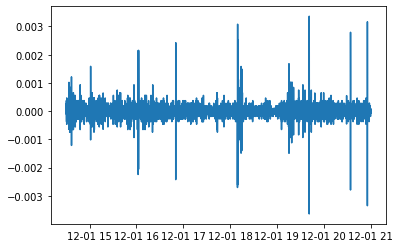

In [54]:
print('Price Timeseries')
plt.plot(tmp.p[:100000]) # plotting by columns
plt.show()

Volume Timeseries


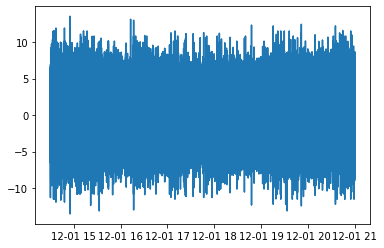

In [56]:
print('Volume Timeseries')
plt.plot(tmp.s[:100000]) # plotting by columns
plt.show()

Price Histogram


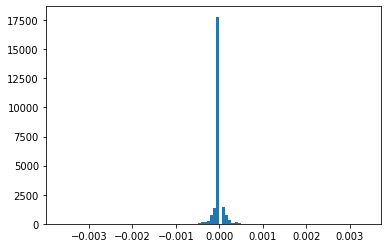

In [58]:
print('Price Histogram')
plt.hist(tmp.p, bins = 100)
plt.show()

Volume Histogram


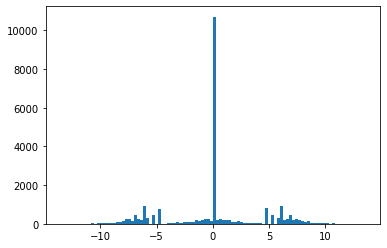

In [59]:
print('Volume Histogram')
plt.hist(tmp.s, bins = 100)
plt.show()

In [ ]:
TYPE      = 'bivariate'
W         = 'T' #minute
LOOKBACK  = 2
EVAL      = 'D' #day


price_generator = tf.data.Dataset.from_generator(
                    generator     = data_generator, args=[TYPE,W,LOOKBACK,EVAL], 
                    output_types  = (tf.float32, tf.float32),
                    output_shapes =(tf.TensorShape([2*(LOOKBACK+1) if TYPE == 'bivariate' else 5*(LOOKBACK+1)]), tf.TensorShape([]))
                    ).repeat().batch(8).prefetch(8)
     
price_generator

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(32, input_shape=(5*MEM,)),
                             tf.keras.layers.Dense(64, activation=tf.nn.tanh),
                             tf.keras.layers.Dense(12, activation=tf.nn.softmax),
                             tf.keras.layers.Dense(32, activation=tf.nn.tanh),
                             tf.keras.layers.Dense(1, activation=tf.nn.relu)])

model.compile(optimizer='adam',
              loss='mean_absolute_error')

model.fit(price_generator, epochs=5, steps_per_epoch=8347)

In [ ]:
#only works on 1D data (predict high based off prev highs only)
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(1,5)),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model.fit(mydataset, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL)